In [ ]:
%mkdir /root/.kaggle
%mv kaggle.json /root/.kaggle/

In [ ]:
!kaggle competitions download -c playground-series-s4e5
!kaggle datasets download -d brijlaldhankour/flood-prediction-factors

 72% 20.0M/28.0M [00:00<00:00, 112MB/s] 
100% 28.0M/28.0M [00:00<00:00, 122MB/s]
Dataset URL: https://www.kaggle.com/datasets/brijlaldhankour/flood-prediction-factors
License(s): MIT
  0% 0.00/680k [00:00<?, ?B/s]
100% 680k/680k [00:00<00:00, 94.1MB/s]


In [ ]:
!unzip playground-series-s4e5.zip -d ./generated
!unzip flood-prediction-factors.zip -d ./real

Archive:  playground-series-s4e5.zip
  inflating: ./generated/sample_submission.csv  
  inflating: ./generated/test.csv    
  inflating: ./generated/train.csv   
Archive:  flood-prediction-factors.zip
  inflating: ./real/flood.csv        


In [ ]:
!pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 3.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial
from skopt import space
from skopt import gp_minimize
from sklearn import model_selection

In [ ]:
# read DATA
train = pd.read_csv('./generated/train.csv',index_col="id")
test = pd.read_csv('./generated/test.csv',index_col="id")
data = pd.read_csv("./real/flood.csv")

In [ ]:
data.columns = train.columns

In [ ]:
train = pd.concat([train,data],axis=0,ignore_index=True)

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 9.1 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostRegressor ,Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [ ]:
initials = test.columns

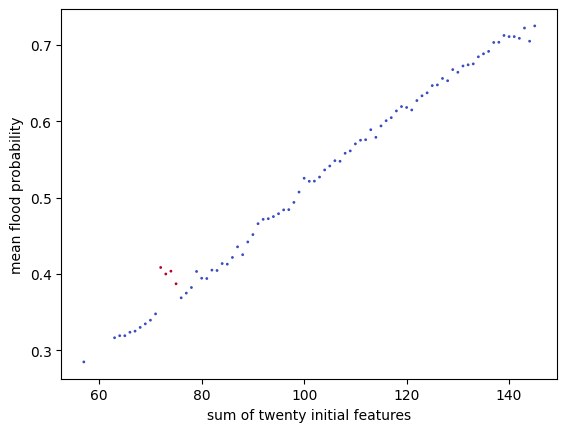

In [ ]:
temp = train.FloodProbability.groupby(train[initials].sum(axis=1)).mean()
plt.scatter(temp.index, temp, s=1, c=(temp.index.isin(np.arange(72, 76))), cmap='coolwarm')
plt.xlabel('sum of twenty initial features')
plt.ylabel('mean flood probability')
plt.show()

In [ ]:
for df in [train, test]:
    df['fsum'] = df[initials].sum(axis=1) # for tree models

In [ ]:
temp_df = pd.DataFrame(np.repeat(train.loc[(train["fsum"]==73) | (train["fsum"]==75)].values,2,axis=0))
temp_df.columns = train.columns

In [ ]:
train = pd.concat([train,temp_df],axis=0,ignore_index=True)
train = train.sample(frac=1).reset_index(drop=True)

In [ ]:
flood_risk_index_feat = ["MonsoonIntensity", "TopographyDrainage", "RiverManagement",
                         "Urbanization", "ClimateChange", "DamsQuality", "Siltation",
                         "AgriculturalPractices", "Encroachments", "DrainageSystems",
                         "CoastalVulnerability", "Landslides", "Watersheds",
                         "DeterioratingInfrastructure", "PopulationScore", "WetlandLoss",
                         "InadequatePlanning", "PoliticalFactors"]

water_run_off_potential_feat =["TopographyDrainage", "Urbanization",
                               "Deforestation", "AgriculturalPractices",
                               "Siltation", "DrainageSystems"]

train["flood_risk_index"] = train[flood_risk_index_feat].mean(axis=1)
train["water_run_off_potential"] = train[water_run_off_potential_feat].mean(axis=1)

test["flood_risk_index"] = test[flood_risk_index_feat].mean(axis=1)
test["water_run_off_potential"] = test[water_run_off_potential_feat].mean(axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train.drop(columns=["FloodProbability"]),train["FloodProbability"] , test_size=0.2, random_state=42)

In [ ]:
train_data = Pool(X_train,y_train)
test_data = Pool(X_test,y_test)
Y = train["FloodProbability"]
X = train.drop(columns=["FloodProbability"])
data = Pool(X,Y)

In [ ]:
cat_params ={'n_estimators':8000,
             'random_state':0,
             'learning_rate': 0.011277016304363601,
             'depth': 8,
             'subsample': 0.8675506657380021,
             'colsample_bylevel': 0.7183884158632279,
             'min_data_in_leaf': 98
            }

In [ ]:
model = CatBoostRegressor(**cat_params)

In [ ]:
test_data = Pool(X_test,y_test)

In [ ]:
model.fit(data,eval_set=test_data)

Streaming output truncated to the last 5000 lines.
3004:	learn: 0.0184094	test: 0.0184337	best: 0.0184337 (3004)	total: 11m 38s	remaining: 19m 20s
3005:	learn: 0.0184094	test: 0.0184336	best: 0.0184336 (3005)	total: 11m 38s	remaining: 19m 20s
3006:	learn: 0.0184093	test: 0.0184336	best: 0.0184336 (3006)	total: 11m 38s	remaining: 19m 19s
3007:	learn: 0.0184093	test: 0.0184335	best: 0.0184335 (3007)	total: 11m 38s	remaining: 19m 19s
3008:	learn: 0.0184092	test: 0.0184335	best: 0.0184335 (3008)	total: 11m 38s	remaining: 19m 19s
3009:	learn: 0.0184091	test: 0.0184334	best: 0.0184334 (3009)	total: 11m 39s	remaining: 19m 19s
3010:	learn: 0.0184091	test: 0.0184333	best: 0.0184333 (3010)	total: 11m 39s	remaining: 19m 18s
3011:	learn: 0.0184090	test: 0.0184333	best: 0.0184333 (3011)	total: 11m 39s	remaining: 19m 18s
3012:	learn: 0.0184090	test: 0.0184333	best: 0.0184333 (3012)	total: 11m 39s	remaining: 19m 18s
3013:	learn: 0.0184089	test: 0.0184332	best: 0.0184332 (3013)	total: 11m 39s	remainin

In [ ]:
pred = model.predict(X_test)
r2_score(y_test,pred)

0.8741563400118054

In [ ]:
ids = list(test.index)
test_prediction = model.predict(test)
test_prediction = test_prediction.reshape(test_prediction.shape[0],).tolist()
df = pd.DataFrame({"id":ids,"FloodProbability":test_prediction})
df.to_csv("submission.csv",index=False)

In [ ]:
df

,id,FloodProbability
0,1117957,0.576862
1,1117958,0.451671
2,1117959,0.448958
3,1117960,0.470258
4,1117961,0.471478
...,...,...
745300,1863257,0.475956
745301,1863258,0.440422
745302,1863259,0.618526
745303,1863260,0.548339


In [ ]:
!kaggle competitions submit -c playground-series-s4e5 -f submission.csv -m "First Submission"